## Exploring temperature data across the world for evidence of climate change

Skeptics of climate change often point to their relatively stable local weather as evidence for denying it. We have all seen images of the gaunt polar bear, but since we may not have first hand experienced the effects of climate change, or are unable to definitively attribute unreliable weather patterns to it, some among us are still doubtful of its occurence. Motivated by this gap in understanding about the phenomenon, I proposed an exploratory data analysis study to my peers as the final project for our first course in the Masters in Information and Data Science program at University of California, Berkeley.  

In this study, my peers and I compared regional average temperatures to the global average to understand if different regions, especially polar regions, experience the effects of climate change differently (more frequently and much sooner) than the other more populous regions of the world. Our project was limited to studying the range of temperature changes, which is a small aspect of the conditions defining climate change.

This notebook is adapted from the final group project and documents the process of data retrieval, cleaning, processing, and exploratory analysis.

In [11]:
## Session Setup
import requests
import urllib.request
from bs4 import BeautifulSoup
import re
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns
import numpy as np
from matplotlib.patches import Rectangle
from matplotlib.collections import PatchCollection
from matplotlib.colors import ListedColormap
import time
%matplotlib inline

### Data Source

Our primary data source for this project comes from (Berkeley Earth)[http://berkeleyearth.org/data-new/], an independent U.S. nonprofit organization focused on environmental data science. Berkley Earth’s global air temperatures over land, dating as far back as 1750, form the basis of this study. The Berkeley Earth method takes temperature observations from a large collection of weather monitoring stations and produces an estimate of the underlying global temperature field across all of the Earth's land areas. Temperature data are in Celsius and are reported as anomalies relative to the Jan 1951 - Dec 1980 average. Each reported monthly anomaly datapoint is accompanied by an uncertainty value that represents the 95% confidence interval for statistical
noise and spatial under sampling effects. Such uncertainties are expected to account for the effects of random noise as well as random biases affecting station trends and random shifts in station baselines. 

As per Berkeley Earth, all reported data values are derived from the full field analysis and may use information from stations a great distance from the target location when more local sources are not available. In general, the temperature anomaly field has significant correlation extending over greater than 1000 km, which allows even distant stations to provide some insight
at times when local coverage may be lacking. Values are reported as missing (i.e. NaN) when station coverage near the location becomes too low. Time averages over intervals with some missing data are reported as long as at least 75% of the necessary values are available.

### Accessing Data

The Berkeley Earth website allows users to download the temperature data by country, state, city, or station by navigating to the appropriate page. Downloading this data for multiple sites can be tedious as one navigates to the page for each location of interest. To reduce the time taken for data downlaods, I explored the (Beautiful Soup library)[https://www.crummy.com/software/BeautifulSoup/bs4/doc/] and learnt a bit about web scraping along the way. I chose five sites for the study:
* Tokyo, Japan
* Berlin, Germany
* Manila, Philippines
* Fairbanks, USA
* Hoshiarpur, India

The first two were chosen to represent city centers, the third to represent equitorial climate, the fourth and fifth for polar regions, and the last is my birthplace. 

In [27]:
# Setting up the url to the data website

local_url = 'http://berkeleyearth.lbl.gov/auto/Local/TAVG/Text/'
regional_url = 'http://berkeleyearth.lbl.gov/auto/Regional/TAVG/Text/'

local_response = requests.get(local_url)
local_response # checks if the site is accessible

regional_response = requests.get(regional_url)
regional_response # checks if the site is accessible

<Response [200]>

In [102]:
# Setting up lat-lon info

tokyo_info = ('Tokyo', '36.17N-139.23E')
berlin_info = ('Berlin', '52.24N-13.14E')
SF_info = ('San Francisco', '37.78N-122.03W')
hoshiarpur_info = ('Hoshiarpur', '31.35N-75.39E')
fairbanks_info = ('Fairbanks', '65.09N-147.45W')
santiago_info =('Santiago', '32.95S-69.89W')

city_info = [tokyo_info, berlin_info, SF_info, hoshiarpur_info, fairbanks_info, santiago_info]

global_info = ('Global', 'global-land')
region_info = [global_info]

all_info =  [tokyo_info, berlin_info, SF_info, hoshiarpur_info, fairbanks_info, santiago_info, global_info]

#### URL Setup 

In [80]:
local_soup = BeautifulSoup(local_response.text, "html.parser")
regional_soup = BeautifulSoup(regional_response.text, "html.parser")

In [83]:
download_urls = []
for i in range(0,len(city_info)):
    name = city_info[i][0]
    x = local_soup.findAll('a', text = re.compile(city_info[i][1]+'-TAVG-Trend'))
    x = (x[0]['href'])
    download_urls.append((name, local_url+x))
    
for i in range(0,len(region_info)):
    name = region_info[i][0]
    x = regional_soup.findAll('a', text = re.compile(region_info[i][1]+'-TAVG-Trend'))
    x = (x[0]['href'])
    download_urls.append((name, regional_url+x))

download_urls

[('Tokyo',
  'http://berkeleyearth.lbl.gov/auto/Local/TAVG/Text/36.17N-139.23E-TAVG-Trend.txt'),
 ('Berlin',
  'http://berkeleyearth.lbl.gov/auto/Local/TAVG/Text/52.24N-13.14E-TAVG-Trend.txt'),
 ('San Francisco',
  'http://berkeleyearth.lbl.gov/auto/Local/TAVG/Text/37.78N-122.03W-TAVG-Trend.txt'),
 ('Hoshiarpur',
  'http://berkeleyearth.lbl.gov/auto/Local/TAVG/Text/31.35N-75.39E-TAVG-Trend.txt'),
 ('Fairbanks',
  'http://berkeleyearth.lbl.gov/auto/Local/TAVG/Text/65.09N-147.45W-TAVG-Trend.txt'),
 ('Santiago',
  'http://berkeleyearth.lbl.gov/auto/Local/TAVG/Text/32.95S-69.89W-TAVG-Trend.txt'),
 ('Global',
  'http://berkeleyearth.lbl.gov/auto/Regional/TAVG/Text/global-land-TAVG-Trend.txt')]

#### Data Retrieval

The following code chunk downloads the data from each of the given URLs and places file in the adjacent 'Data' folder

In [84]:
for i in range(0, len(download_urls)):
    urllib.request.urlretrieve(download_urls[i][1], './Data/' + download_urls[i][0] + '.txt')
    
time.sleep(1)

#### Data Cleanup and Formatting

Once the data is downloaded into the 'Data' folder, we can read it in to the Jupyter notebook and begin processing it.

In [85]:
# Step 1 - get monthly averages for each location

def get_monthly_averages(data_location, line_number):
    data = open(data_location)
    content = data.readlines()
    average_data = content[line_number][8:-2].split()
    average_list = [float(i) for i in average_data]
    data.close()
    return average_list

In [86]:
Tokyo_av = get_monthly_averages('Data/Tokyo.txt', 52)
Berlin_av = get_monthly_averages('Data/Berlin.txt', 52)
SF_av = get_monthly_averages('Data/San Francisco.txt', 52)
Hoshiarpur_av = get_monthly_averages('Data/Hoshiarpur.txt', 52)
Fairbanks_av = get_monthly_averages('Data/Fairbanks.txt', 52)
Santiago_av = get_monthly_averages('Data/Santiago.txt', 52)

Global_av = get_monthly_averages('Data/Global.txt', 54)



monthly_data = pd.DataFrame(np.column_stack([Global_av, Tokyo_av, Berlin_av, 
                                             SF_av, Hoshiarpur_av,
                                             Fairbanks_av, Santiago_av]),
                           columns = ['Global', 'Tokyo', 'Berlin', 'SF', 'Hoshiarpur', 'Fairbanks', 'Santiago'])

index = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']

monthly_data.index = index
monthly_data



,Global,Tokyo,Berlin,SF,Hoshiarpur,Fairbanks,Santiago
January,2.60,0.83,-0.78,8.47,12.32,25.24,13.19
February,3.21,1.73,0.16,10.72,15.17,-20.91,12.50
March,5.30,5.16,3.73,11.87,20.38,-14.36,10.46
April,8.29,11.11,8.03,13.43,26.27,-3.32,6.57
May,11.29,16.03,12.96,16.00,30.86,6.73,3.26
June,13.43,19.74,16.85,18.41,33.13,12.92,0.01
July,14.31,23.57,18.11,19.79,30.76,14.26,-0.15
August,13.84,24.76,17.77,19.75,29.75,11.63,1.46
September,12.05,20.46,14.33,19.49,28.75,5.00,3.53
October,9.21,14.17,9.47,16.68,24.79,-6.11,6.01


In [88]:
tokyo_land = pd.read_fwf('Data/Tokyo.txt', skiprows = 68)
berlin_land = pd.read_fwf('Data/Berlin.txt', skiprows = 68)
SF_land = pd.read_fwf('Data/San Francisco.txt', skiprows = 68)
hoshiarpur_land = pd.read_fwf('Data/Hoshiarpur.txt', skiprows = 68)
fairbanks_land = pd.read_fwf('Data/Fairbanks.txt', skiprows = 68)
santiago_land = pd.read_fwf('Data/Santiago.txt', skiprows = 68)
global_land = pd.read_fwf('Data/Global.txt', skiprows = 70)



In [98]:
def format_data(data) : # Subset the needed columns and rename as needed
    formatted_data = data.iloc[:,0:4]
    formatted_data.columns = ['Year', 'Month', 'Anomaly', 'Unc']   
    return formatted_data
    
def count_missing(data):
    nulls = data.isnull().sum().sum()
    total = data.count()[0]*2 # counting twice to count values in columns Anomaly and Unc
    return [total, nulls, f'{(nulls/total)*100:.2f}%']

In [103]:
land_data = [tokyo_land, berlin_land, SF_land, hoshiarpur_land, fairbanks_land, santiago_land, global_land]
land_data = map(format_data, land_data)
missing_data = map(count_missing, land_data)

df = pd.DataFrame(np.row_stack(list(missing_data)),
            columns = ['# Total Values', '# Missing Values', '# Missing %'])

index = [i[0] for i in all_info]

df.index = index
df

# pick up here

,# Total Values,# Missing Values,# Missing %
Tokyo,4836,294,6.08%
Berlin,6668,56,0.84%
San Francisco,4128,0,0.00%
Hoshiarpur,4916,582,11.84%
Fairbanks,4632,146,3.15%
Santiago,3976,0,0.00%
Global,6504,2,0.03%


In [70]:
month_data = [1,2,3,4,5,6,7,8,9,10,11,12]

global_monthly_land_avg = pd.DataFrame({'Month': month_data, 'Average': Global_av})
tokyo_monthly_land_avg = pd.DataFrame({'Month': month_data, 'Average': Tokyo_av})
berlin_monthly_land_avg = pd.DataFrame({'Month': month_data, 'Average': Berlin_av})
SF_monthly_land_avg = pd.DataFrame({'Month': month_data, 'Average': SF_av})
hoshiarpur_monthly_land_avg = pd.DataFrame({'Month': month_data, 'Average': Hoshiarpur_av})
antarctica_monthly_land_avg = pd.DataFrame({'Month': month_data, 'Average': Antarctica_av})
greenland_monthly_land_avg = pd.DataFrame({'Month': month_data, 'Average': Greenland_av})

def calculate_absolute_monthly_temp(anomaly_df, average_df):
    df =  pd.merge(anomaly_df, average_df, on = "Month").sort_values(['Year', 'Month'])
    Date = pd.to_datetime(df['Year'].astype(str) + ' ' + df['Month'].astype(str))
    df = df.set_index(Date)
    df['Monthly_Avg'] = df['Average'] + df['Anomaly']
    df = df.loc[:,('Year', 'Month', 'Monthly_Avg', 'Anomaly', 'Unc')]
    return df  


global_land_abs_monthly = calculate_absolute_monthly_temp(global_land, global_monthly_land_avg)
tokyo_land_abs_monthly = calculate_absolute_monthly_temp(tokyo_land, tokyo_monthly_land_avg)
berlin_land_abs_monthly = calculate_absolute_monthly_temp(berlin_land, berlin_monthly_land_avg)
SF_land_abs_monthly = calculate_absolute_monthly_temp(SF_land, SF_monthly_land_avg)
hoshiarpur_land_abs_monthly = calculate_absolute_monthly_temp(hoshiarpur_land, hoshiarpur_monthly_land_avg)
antarctica_land_abs_monthly = calculate_absolute_monthly_temp(antarctica_land, antarctica_monthly_land_avg)
greenland_land_abs_monthly = calculate_absolute_monthly_temp(greenland_land, greenland_monthly_land_avg)


In [71]:
global_land_abs_monthly = calculate_absolute_monthly_temp(global_land, global_monthly_land_avg)
tokyo_land_abs_monthly = calculate_absolute_monthly_temp(tokyo_land, tokyo_monthly_land_avg)
berlin_land_abs_monthly = calculate_absolute_monthly_temp(berlin_land, berlin_monthly_land_avg)
SF_land_abs_monthly = calculate_absolute_monthly_temp(SF_land, SF_monthly_land_avg)
hoshiarpur_land_abs_monthly = calculate_absolute_monthly_temp(hoshiarpur_land, hoshiarpur_monthly_land_avg)
antarctica_land_abs_monthly = calculate_absolute_monthly_temp(antarctica_land, antarctica_monthly_land_avg)
greenland_land_abs_monthly = calculate_absolute_monthly_temp(greenland_land, greenland_monthly_land_avg)

# convert to yearly - only to plot initial charts
global_land_df_yearly = pd.DataFrame(global_land_abs_monthly.resample('Y').mean())
tokyo_land_df_yearly = pd.DataFrame(tokyo_land_abs_monthly.resample('Y').mean())
SF_land_df_yearly = pd.DataFrame(SF_land_abs_monthly.resample('Y').mean())
berlin_land_df_yearly = pd.DataFrame(berlin_land_abs_monthly.resample('Y').mean())
hoshiarpur_land_df_yearly = pd.DataFrame(hoshiarpur_land_abs_monthly.resample('Y').mean())
antarctica_land_df_yearly = pd.DataFrame(antarctica_land_abs_monthly.resample('Y').mean())
greenland_land_df_yearly = pd.DataFrame(greenland_land_abs_monthly.resample('Y').mean())


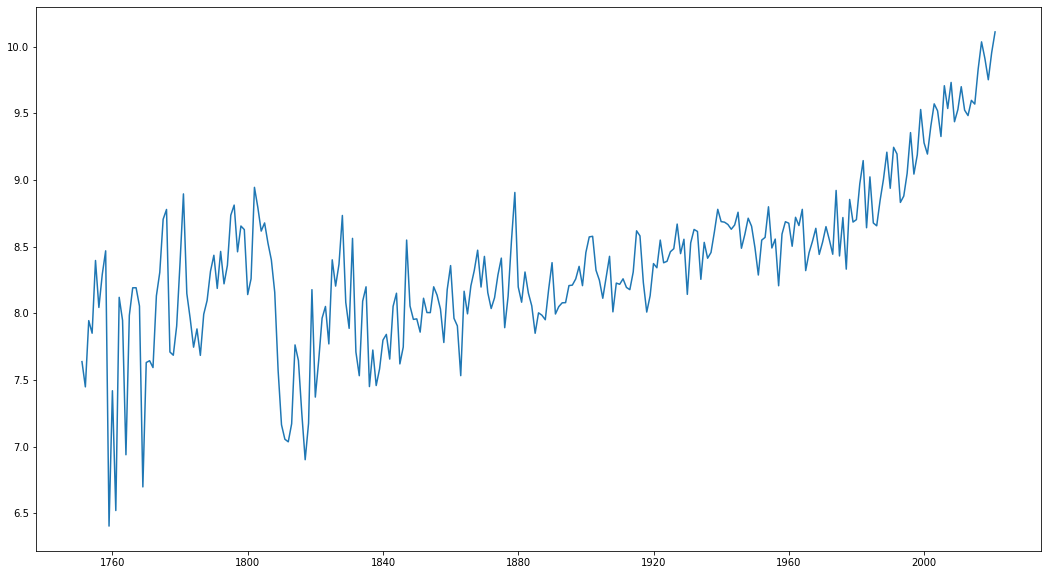

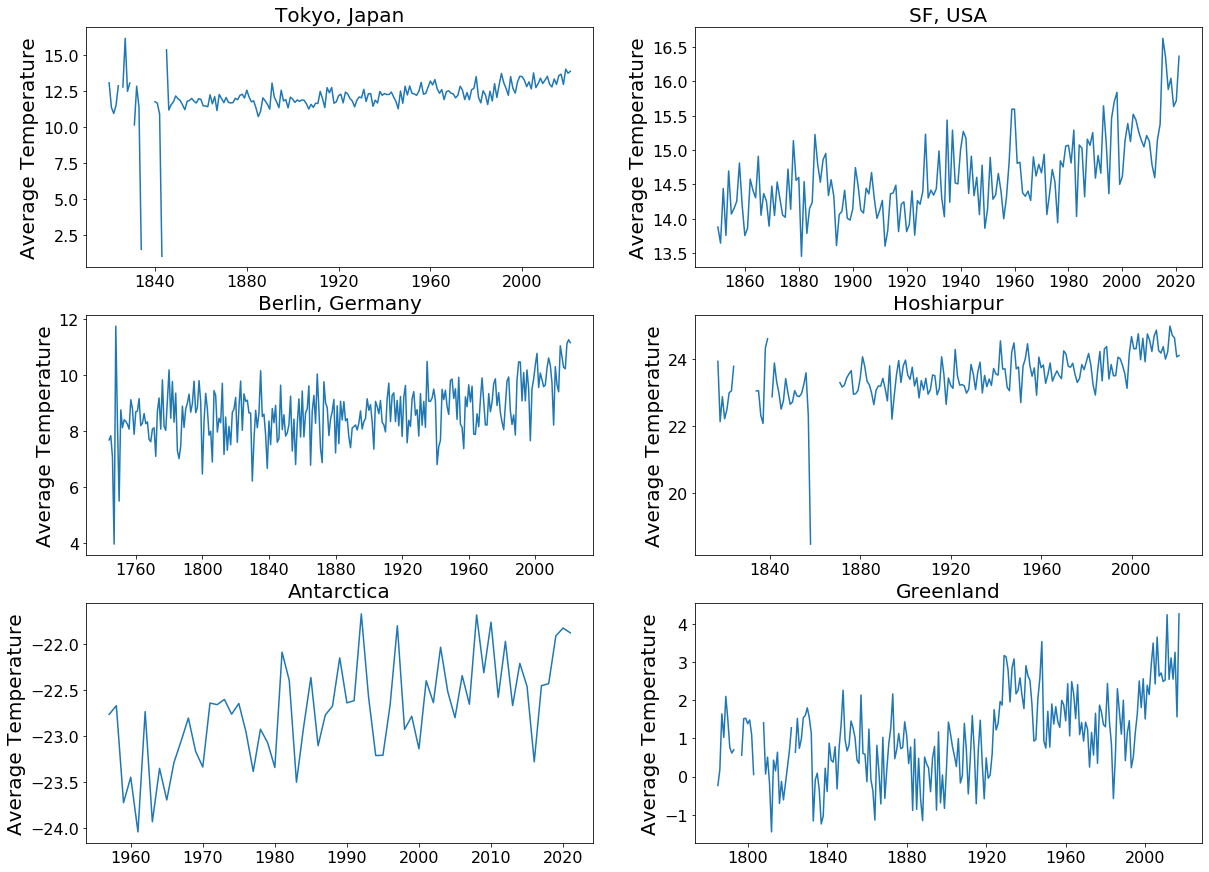

In [72]:
figure(num=None, figsize=(18, 10)) # increase size of image
plt.plot(global_land_df_yearly.Monthly_Avg, label = "Global Land")

fig, axs = plt.subplots(3,2, figsize=(20, 15))
axs[0,0].plot(tokyo_land_df_yearly.Monthly_Avg)
axs[0,0].set_title('Tokyo, Japan', fontsize = 20)
axs[0,1].plot(SF_land_df_yearly.Monthly_Avg)
axs[0,1].set_title('SF, USA', fontsize = 20)
axs[1,0].plot(berlin_land_df_yearly.Monthly_Avg)
axs[1,0].set_title('Berlin, Germany', fontsize = 20)
axs[1,1].plot(hoshiarpur_land_df_yearly.Monthly_Avg)
axs[1,1].set_title('Hoshiarpur', fontsize = 20)
axs[2,0].plot(antarctica_land_df_yearly.Monthly_Avg)
axs[2,0].set_title('Antarctica', fontsize = 20)
axs[2,1].plot(greenland_land_df_yearly.Monthly_Avg)
axs[2,1].set_title('Greenland', fontsize = 20)


for ax in axs.flat:
    ax.set(ylabel='Average Temperature')
    ax.yaxis.get_label().set_fontsize(20)
    ax.tick_params(axis='y', labelsize=16)
    ax.tick_params(axis='x', labelsize=16)

In [73]:
def create_heatmap(df, name):    

    FIRST =  1850
    LAST = 2019  # inclusive

    # Reference period for the center of the color scale

    FIRST_REFERENCE = 1951 # TODO: find reasoning for reference period
    LAST_REFERENCE = 1980
    LIM = 0.9 # degree - chosen for color aesthetics

    df_yearly_indexed = df.set_index("Year")

    anomaly = df_yearly_indexed.loc[FIRST:LAST, 'Anomaly'].dropna()
    reference = anomaly.loc[FIRST_REFERENCE:LAST_REFERENCE].mean() # setting the reference for the color scale

    cmap = ListedColormap([
        '#08306b', '#08519c', '#2171b5', '#4292c6',
        '#6baed6', '#9ecae1', '#c6dbef', '#deebf7',
        '#fee0d2', '#fcbba1', '#fc9272', '#fb6a4a',
        '#ef3b2c', '#cb181d', '#a50f15', '#67000d',
    ])

    fig = plt.figure(figsize=(10, 2))

    ax = fig.add_axes([0, 0, 1, 1])
    ax.set_axis_off()
    ax.set_title(name, fontsize = 20)

    col = PatchCollection([
        Rectangle((y, 0), 1, 1)
        for y in range(FIRST, LAST + 1)
    ])

    # set data, colormap and color limits

    col.set_array(anomaly)
    col.set_cmap(cmap)
    col.set_clim(reference - LIM, reference + LIM)
    ax.add_collection(col)

    ax.set_ylim(0, 1)
    ax.set_xlim(FIRST, LAST + 1)

    fig

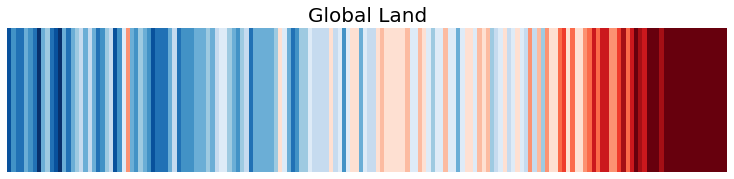

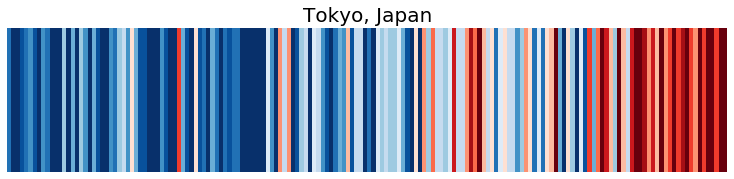

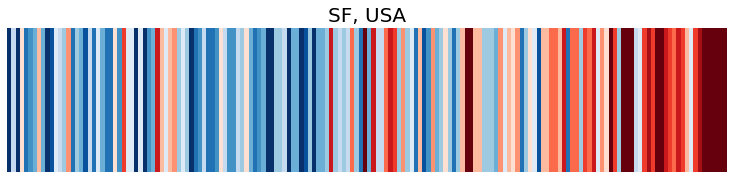

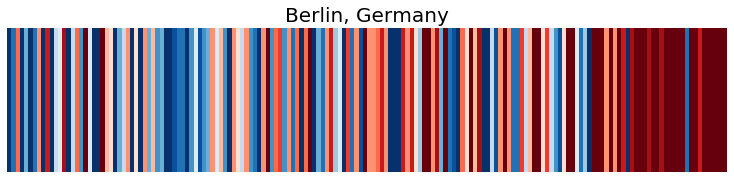

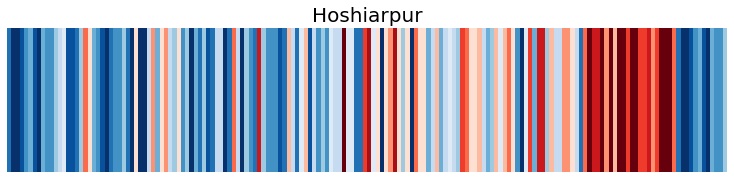

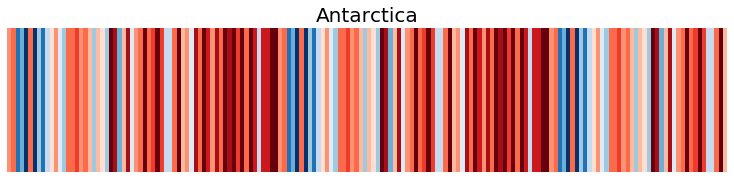

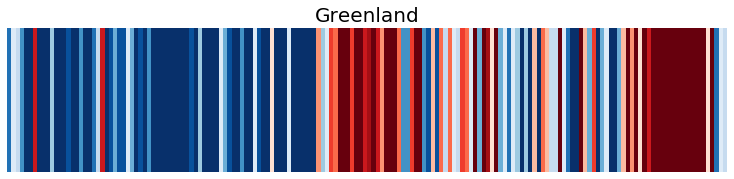

In [74]:
create_heatmap(global_land_df_yearly, name = "Global Land")
create_heatmap(tokyo_land_df_yearly, name = "Tokyo, Japan")
create_heatmap(SF_land_df_yearly, name = "SF, USA")
create_heatmap(berlin_land_df_yearly, name = "Berlin, Germany")
create_heatmap(hoshiarpur_land_df_yearly, name = "Hoshiarpur")
create_heatmap(antarctica_land_df_yearly, name = "Antarctica")
create_heatmap(greenland_land_df_yearly, name = "Greenland")


In [75]:
def get_regional_deviation(global_df, regional_df):
    regional_df["deviation"] = global_df.Anomaly - regional_df.Anomaly
    regional_deviation_yearly = pd.DataFrame(regional_df.deviation.resample('Y').mean())
    return regional_deviation_yearly

In [76]:
tokyo_land_deviation = get_regional_deviation(global_land_df_yearly, tokyo_land_df_yearly)
SF_land_deviation = get_regional_deviation(global_land_df_yearly, SF_land_df_yearly)
berlin_land_deviation = get_regional_deviation(global_land_df_yearly, berlin_land_df_yearly)
hoshiarpur_land_deviation = get_regional_deviation(global_land_df_yearly, hoshiarpur_land_df_yearly)
antarctica_land_deviation = get_regional_deviation(global_land_df_yearly, antarctica_land_df_yearly)
greenland_land_deviation = get_regional_deviation(global_land_df_yearly, greenland_land_df_yearly)

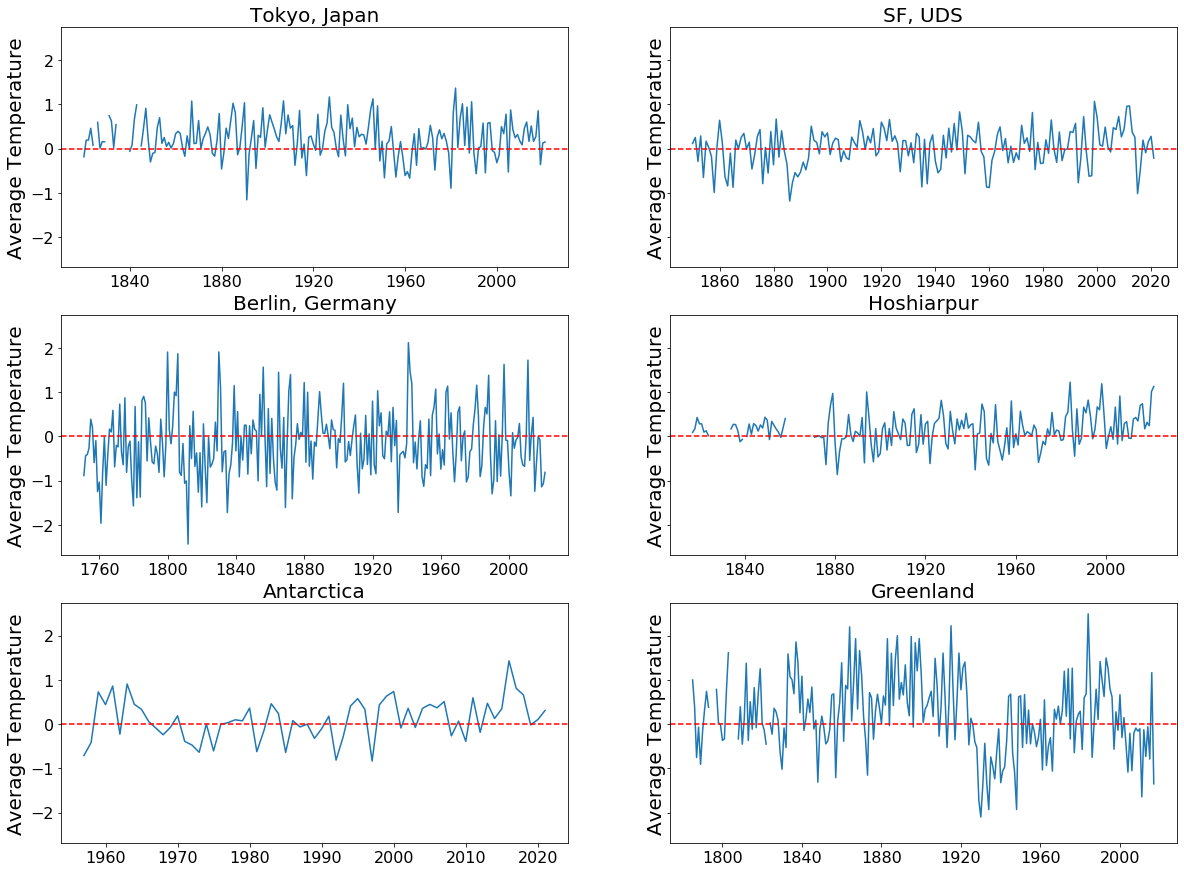

In [78]:
fig, axs = plt.subplots(3,2, figsize=(20, 15), sharey=True)
axs[0,0].plot(tokyo_land_deviation.deviation)
axs[0,0].set_title('Tokyo, Japan', fontsize = 20)
axs[0,0].axhline(0, color = 'red', ls='--')
axs[0,1].plot(SF_land_deviation.deviation)
axs[0,1].set_title('SF, UDS', fontsize = 20)
axs[0,1].axhline(0, color = 'red', ls='--')
axs[1,0].plot(berlin_land_deviation.deviation)
axs[1,0].set_title('Berlin, Germany', fontsize = 20)
axs[1,0].axhline(0, color = 'red', ls='--')
axs[1,1].plot(hoshiarpur_land_deviation.deviation)
axs[1,1].set_title('Hoshiarpur', fontsize = 20)
axs[1,1].axhline(0, color = 'red', ls='--')
axs[2,0].plot(antarctica_land_deviation.deviation)
axs[2,0].set_title('Antarctica', fontsize = 20)
axs[2,0].axhline(0, color = 'red', ls='--')
axs[2,1].plot(greenland_land_deviation.deviation)
axs[2,1].set_title('Greenland', fontsize = 20)
axs[2,1].axhline(0, color = 'red', ls='--')

for ax in axs.flat:
    ax.set(ylabel='Average Temperature')
    ax.yaxis.get_label().set_fontsize(20)
    ax.tick_params(axis='y', labelsize=16)
    ax.tick_params(axis='x', labelsize=16)
    